## 0 - Libraries

In [1]:
!pip install transformers timm --quiet
!pip install pandas albumentations --quiet
!pip install matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.6 MB/s eta 0:00:00


In [2]:
import os
import csv
import timm
import torch
import requests
import itertools
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
from tqdm.auto import tqdm
import albumentations as A
import torch.nn.functional as F
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import model_clip

## 1 - USE CLIP MODEL FOR APP

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
my_clip = model_clip.CLIPModel().to(device)
my_clip.load_state_dict(torch.load('/content/drive/MyDrive/AI/ERA_course/session19/my_clip',map_location=torch.device(device)))
my_clip.eval()

CLIPModel(
  (image_encoder): ImageEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [8]:
# load validation data (400)
file = open("/content/drive/MyDrive/AI/ERA_course/session19/val_genre.pkl",'rb')
genre = pickle.load(file)
file.close()

file = open("/content/drive/MyDrive/AI/ERA_course/session19/val_images_url.pkl",'rb')
poster_url = pickle.load(file)
file.close()

movie_poster_embeddings = torch.load('/content/drive/MyDrive/AI/ERA_course/session19/val_image_embeddings.pt',map_location=torch.device(device))

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [11]:
n = 4
query = 'i want to watch funny movie'
encoded_query = tokenizer([query])
batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
}
text_features   = my_clip.text_encoder(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
text_embeddings = my_clip.text_projection(text_features)

image_embeddings_n = F.normalize(movie_poster_embeddings, p=2,  dim=-1)
text_embeddings_n  = F.normalize(text_embeddings,  p=2,  dim=-1)
dot_similarity = text_embeddings_n @ image_embeddings_n.T
values, indices = torch.topk(dot_similarity.squeeze(0), n)
print(values, indices)

tensor([0.1290, 0.1280, 0.1268, 0.1264], grad_fn=<TopkBackward0>) tensor([ 83, 239,  54, 277])


User Query>>>>> i want to watch funny movie


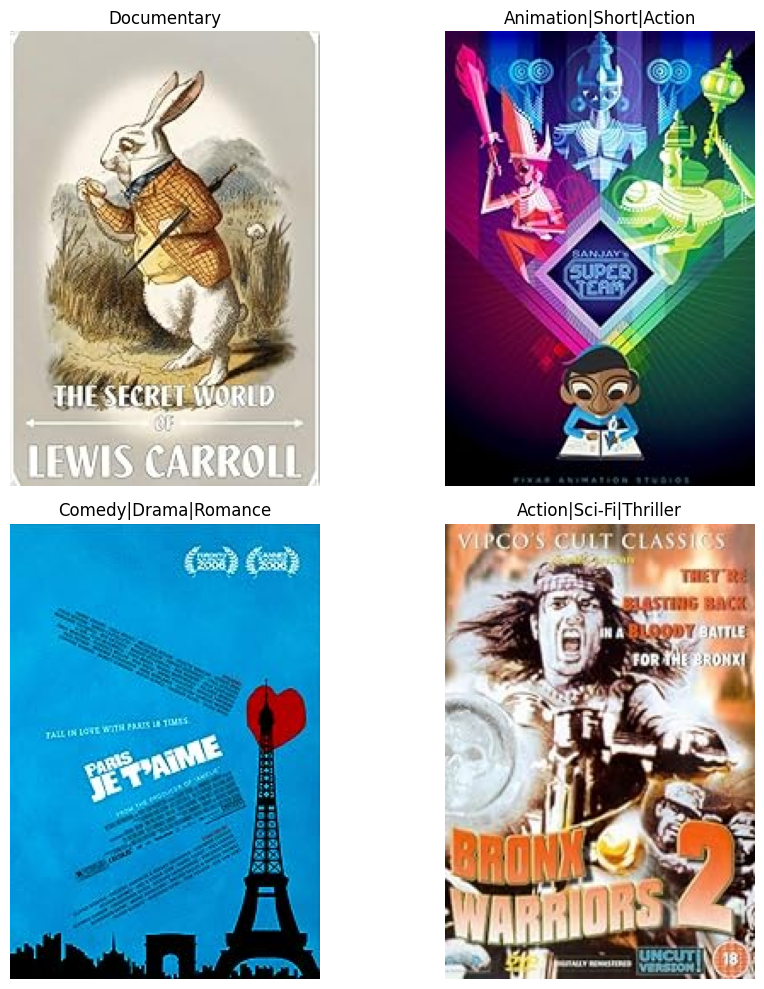

In [12]:
matches = [poster_url[idx] for idx in indices]
matches_genre = [genre[idx] for idx in indices]
print(f"User Query>>>>> {query}")

_, axes = plt.subplots(2, 2, figsize=(10, 10))

for m, g, ax in zip(matches, matches_genre, axes.flatten()):
  img_https_link = 'https://images-na.ssl-images-amazon.com/images/M/' + m.split('/')[-1]
  image = Image.open(requests.get(img_https_link, stream=True).raw).convert('RGB')
  ax.imshow(image)
  ax.set_title(g)
  ax.axis("off")

plt.tight_layout()
plt.show()